In [1]:
import pandas as pd
import datetime
import urllib
import os
import glob
import warnings
import time
import dask.dataframe as dd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import scipy
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm_notebook
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score

warnings.filterwarnings('ignore')

## Abstract
Broad spectrum of urban activities including mobility can be modeled as temporal networks evolving over time. Abrupt changes in urban dynamics caused by events such as disruption of civic operations, mass crowd gatherings, holidays and natural disasters are potentially reflected in these temporal mobility networks. Identification and early detecting of such abnormal developments is of critical importance for transportation planning and security. Anomaly detection from high dimensional network data is a challenging task as edge level measurements often have low values and high variance resulting in high noise-to-signal ratio. In this study, we propose three approaches to tackle curse of dimensionality and noisiness of the original data. Our methods consists of i) aggregate ridership by date, apply SARIMA model to predict it, and select anomalies based on residuals; ii) apply PCA to ridership network, and cluster data using Gaussian Mixture Model; iii) perform VARMA model on leading principal components and then apply GMM to detect anomalies based on residuals. 

## Dataset
New York City Taxi and Limousine Commission provides yellow taxi, green taxi, and for-hire vehicles' trip records include fields capturing pick-up and drop-off dates/times, pick-up/drop-off locations. The pick-up/drop-off locations are aggregated into 263 taxi zones. Here, we only take yellow taxis and aggregate the traffic volume by date.

## Refenrence
He, Mingyi, et al. "Pattern and anomaly detection in urban temporal networks." arXiv preprint arXiv:1912.01960 (2019).

### SARIMA
A seasonal autoregressive integrated moving average (SARIMA) model is one step different from an ARIMA model based on the concept of seasonal trends.

ARIMA(p, d, q) × (P, D, Q)S
with p = non-seasonal AR order, d = non-seasonal differencing, q = non-seasonal MA order, P = seasonal AR order, D = seasonal differencing, Q = seasonal MA order, and S = time span of repeating seasonal pattern.

A seasonal ARIMA model uses differencing at a lag equal to the number of seasons (s) to remove additive seasonal effects. As with lag 1 differencing to remove a trend, the lag s differencing introduces a moving average term. The seasonal ARIMA model includes autoregressive and moving average terms at lag s.

— Page 142, Introductory Time Series with R, 2009.

Seasonal ARIMA models can potentially have a large number of parameters and combinations of terms. Therefore, it is appropriate to try out a wide range of models when fitting to data and choose a best fitting model using an appropriate criterion …

— Pages 143-144, Introductory Time Series with R, 2009.

check more information about SARIMA here: https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

### data downloading

In [2]:
!mkdir data
dataDir = 'data/'
Years = [2018]
Months = range(1,13)
VehicleTypes = ['yellow']

mkdir: cannot create directory ‘data’: File exists


In [3]:
def getUrl(cabtype,year,month):
    baseUrl = 'https://s3.amazonaws.com/nyc-tlc/trip+data/'
    
    if len(str(month)) == 1:
        fileName = '%s_tripdata_%s-0%s.csv'%(cabtype,year,month)
    else:
        fileName = '%s_tripdata_%s-%s.csv'%(cabtype,year,month)
        
    return baseUrl + fileName, fileName        

In [4]:
for year in Years:
    for month in Months:
        for cabtype in VehicleTypes:
            url, fileName = getUrl(cabtype,year,month)
            
            print("Downloading..: "+str(fileName), end='\r')
            
            if fileName in os.listdir(dataDir):
                print("file exists...", end='\r')
                continue
            
            filePath = os.path.join(dataDir, fileName)
            try:
                urllib.request.urlretrieve(url, filePath)
            except:
                # if fails remove the incomplete file
                os.remove(filePath)
                try:
                    # start again after a delay of 2 min
                    time.sleep(60*2)
                    urllib.request.urlretrieve(url, filePath)
                except:
                    print("Download this file later !!!!!!!!!!!!!")
                    pass

            print()

### data cleaning

In [ ]:
# using dask instead of pandas to read all csv files in one folder
# in this way, we can not only avoid the for loop, but also speed up calculation
df = dd.read_csv('data/*.csv')
df = df.compute()

In [ ]:
# subset sample the dataset, and exclude data points which are not in our target year, 2018.
df = df[['tpep_pickup_datetime','PULocationID','DOLocationID','passenger_count']]
df = df.dropna(subset=['tpep_pickup_datetime','PULocationID','DOLocationID'])
df['date'] = df['tpep_pickup_datetime'].apply(lambda x:x.split(' ')[0])
df['year'] = df['date'].apply(lambda x:x.split('-')[0])

df = df[df['year']=='2018']

# group by the whole dataset by date, pickup, and drop-off location to get daily OD pairs
df = df.groupby(['date','PULocationID','DOLocationID']).sum().reset_index()

In [ ]:
df.to_csv('processedDailyTZ.csv',index=False)

In [5]:
df = pd.read_csv('processedDailyTZ.csv')

## Phase 1
1. time-series analysis on aggregated ridership: total ridership = linear trend + seasonality + errors
2. outlier detection - report the strongest relative errors (error/trend+seasonality prediction

In [6]:
# get daily total ridership without OD
dfDaily = df.groupby(['date']).agg({'passenger_count':sum})
dfDaily.index = pd.to_datetime(dfDaily.index)
dfDaily.head()

,passenger_count
date,
2018-01-01,406391
2018-01-02,388447
2018-01-03,427504
2018-01-04,199159
2018-01-05,431248


<AxesSubplot:xlabel='date'>

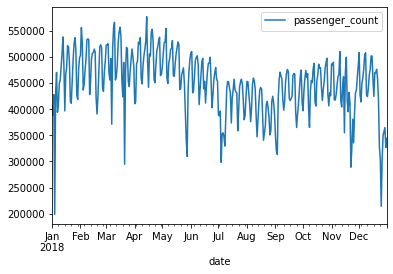

In [7]:
dfDaily.plot()

In [8]:
# check stationarity
series = dfDaily['passenger_count']
result = adfuller(series)
print('p-value: %f' % result[1])
result = adfuller(series.diff().dropna())
print('p-value: %f' % result[1])

p-value: 0.176497
p-value: 0.000000


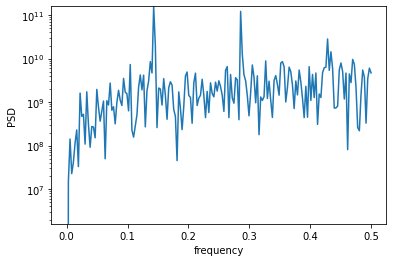

Strongest period length = 6.999999999999999


In [9]:
# check seasonality
series = series.diff().dropna()
f, PSD = scipy.signal.periodogram(series)
plt.semilogy(f, PSD)
plt.xlabel('frequency')
plt.ylabel('PSD')
# plt.xlim(0.005,0.25)
plt.ylim(max(PSD)/1e5,max(PSD))
PSD = PSD[f>0.005]
f = f[f>0.005]
plt.show()
print('Strongest period length = {}'.format(1/f[np.argmax(PSD)]))

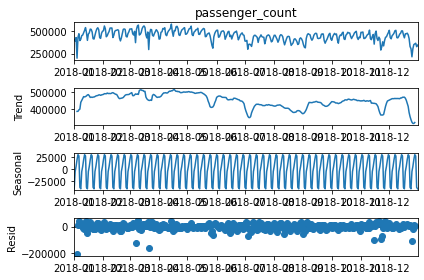

In [10]:
# seasonality and trend decomposition
res = sm.tsa.seasonal_decompose(dfDaily['passenger_count'],model='additive',freq=7)
res.plot()
plt.show()

In [11]:
# as seasonality exsit, we need to remoce seasonality at first, 
# then check autocorrelation and partial autocorrelation
series = series.diff(7).dropna()

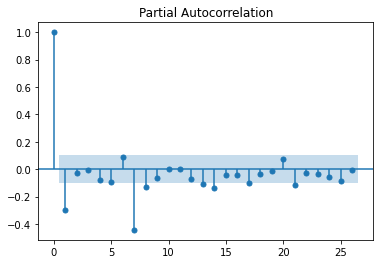

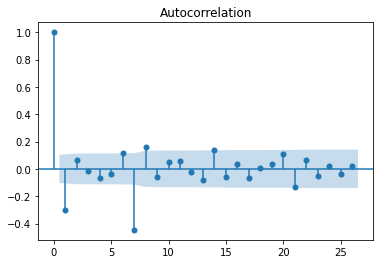

In [12]:
_ = plot_pacf(series)
_ = plot_acf(series)

Keep in mind that although we took the difference over a period of 7 days, the order of seasonal differencing (D) is 1, because we only took the difference once.

We can see from the PACF that we have a significant peak at lag 1, which suggest an AR(1) process. Also, we have another peak at lag 7, suggesting a seasonal autoregressive process of order 1 (P = 1). Same for the ACF plot.

Although these plots can give us a rough idea of the processes in play, it is better to test multiple scenarios and choose the model that yield the lowest AIC. Note that we will only test different values for the parameters p, P, q and Q. We know that both seasonal and non-seasonal integration parameters should be 1, and that the length of the season is 7.

###  grid search

In [13]:
# make combination of p,d,q
series = dfDaily['passenger_count']
p = q = range(0, 3)
D = d = range(0, 3)
s = 7
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in pdq]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))


Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 1) x (0, 0, 2, 7)


In [14]:
# fit all possible combination of pdq
# select the parameter set which returns the lowest AIC
# more about AIC: https://machinelearningmastery.com/probabilistic-model-selection-measures/
aicDict = {}
for param in tqdm_notebook(pdq):
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(dfDaily,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            aicDict[(param,param_seasonal)] = results.aic
        except: 
            continue

In [23]:
# fit the best parameter from the last cell into SARIMA model
model=sm.tsa.statespace.SARIMAX(endog=dfDaily,order=min(aicDict, key=aicDict.get)[0],seasonal_order=min(aicDict, key=aicDict.get)[1],trend='c',enforce_invertibility=False)
results=model.fit()
print(results.summary())

                                       SARIMAX Results                                        
Dep. Variable:                        passenger_count   No. Observations:                  365
Model:             SARIMAX(0, 1, 0)x(1, 2, [1, 2], 7)   Log Likelihood               -4288.758
Date:                                Thu, 23 Sep 2021   AIC                           8587.516
Time:                                        14:01:09   BIC                           8606.805
Sample:                                    01-01-2018   HQIC                          8595.194
                                         - 12-31-2018                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    505.1537    974.618      0.518      0.604   -1405.063    2415.370
ar.

### anomaly detection
a simple definition of anomalies: residuals deviate 3 std away.

In [24]:
# calculate how many standard deviation away from the mean for each day's residual
residDF = pd.DataFrame(results.resid)
residDF.columns = ['resid']
residDF['dev'] = np.abs(residDF['resid'] - residDF['resid'].mean())/residDF['resid'].std()
anomaly = residDF[residDF['dev']>3]

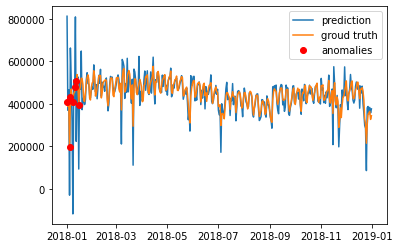

In [25]:
plt.plot(residDF.index,dfDaily['passenger_count']+results.resid, label='prediction')
plt.plot(residDF.index,dfDaily['passenger_count'],label='groud truth')
plt.plot(anomaly.index,dfDaily.loc[dfDaily.index.isin(anomaly.index)],'ro',label='anomalies')
plt.legend()

In [26]:
anomaly

,resid,dev
date,,
2018-01-01,405897.359112,6.852996
2018-01-04,-228838.640888,3.713981
2018-01-05,231595.359112,3.951246
2018-01-08,-527391.674423,8.684241
2018-01-11,328835.882322,5.570090
2018-01-12,-283653.768831,4.626534
2018-01-15,-303334.054544,4.954168


### We detected 7 abnormal days in the last step. But can we trust the result? Even no wide-accepted definition of urban anomalies, intuitively, some days absolutely have different patterns—for example, federal holidays and storms. Let's name those days as artificially selected events.

In [27]:
event = pd.read_csv('event.csv')
anomaly['Date'] = anomaly.index.astype(str)
anomaly = anomaly[['Date']]
anomaly['detected'] = 'yes'
results = anomaly.merge(event, on='Date',how='outer')
results['Type'] = results['Type'].fillna('None')
results['Name'] = results['Name'].fillna('None')
results

,Date,detected,Type,Name
0,2018-01-01,yes,National Holiday,New Year's Day
1,2018-01-04,yes,Extreme Weather,Blizzard
2,2018-01-05,yes,Extreme Weather,Blizzard
3,2018-01-08,yes,None,None
4,2018-01-11,yes,None,None
5,2018-01-12,yes,None,None
6,2018-01-15,yes,National Holiday,"Martin Luther King, Jr. Day"
7,2018-02-19,NaN,National Holiday,Washington's Birthday
8,2018-03-21,NaN,Extreme Weather,Snow Storm
9,2018-03-22,NaN,Extreme Weather,Snow Storm


In [28]:
print('detected days:', len(results.loc[(results['detected']=='yes')]))
print('events in detected days:', len(results.loc[(results['detected']=='yes')&(results['Type']!='None')])
      , '/',len(event))
print('undetected events:', len(results.loc[(results['detected']!='yes')&(results['Type']!='None')]), '/',len(event))

detected days: 7
events in detected days: 4 / 18
undetected events: 14 / 18


### confusion matrix

confusion matrix is a specific table layout that allows visualization of the performance of an algorithm. Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class, or vice versa – both variants are found in the literature. The name stems from the fact that it makes it easy to see whether the system is confusing two classes (i.e. commonly mislabeling one as another).

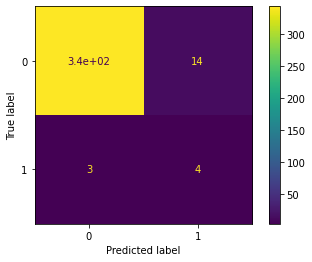

In [31]:
cmdf = pd.DataFrame({'date':dfDaily.index.astype(str)})
cmdf['event'] = 0
cmdf.loc[cmdf.date.isin(event.Date),'event'] = 1
cmdf['anomaly'] = 0
cmdf.loc[cmdf.date.isin(anomaly.Date),'anomaly'] = 1
cm = confusion_matrix(cmdf.anomaly, cmdf.event)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()

### f1 score
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. 

The formula for the F1 score is:
F1 = 2 * (precision * recall) / (precision + recall) 

Precision = tp / (tp+fp) 

Recall = tp / (tp+fn)

However, please keep in mind the f1 score is not the best metrics here as our labels are highly imbalanced.

In [32]:
f1_score(cmdf.anomaly, cmdf.event)

0.32

## Phase 2
1. PCA of the ridership network between each taxi zone normalized by the total daily ridership vector (per taxi zone).
2. Visualize weekdays and weekends with different colors on leading PCs
3. Outlier detection within the plot above through Gaussian Mixtures; report the days with strongest outliers

In gaussian mixture model, anomalies are selected based on likelihood. We can arbitarily set 1% or 5% days have the lowest likelihood as anomalies.

In [33]:
df = pd.pivot_table(df,columns=['PULocationID','DOLocationID'],index='date').fillna(0)

In [34]:
dfNormalize = pd.DataFrame(df.values / df.values.sum(axis=1,keepdims=True))
dfNormalize.index = df.index

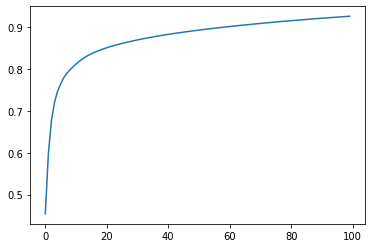

In [35]:
pca = PCA(100)
dfNormalizePC = pca.fit_transform(dfNormalize)
explained_variance = pca.explained_variance_ratio_
plt.plot(explained_variance.cumsum())

#### roughly speaking, 20 is the elbow of explained variance curve.

Text(0.5, 0.92, 'first 3 leading PCs')

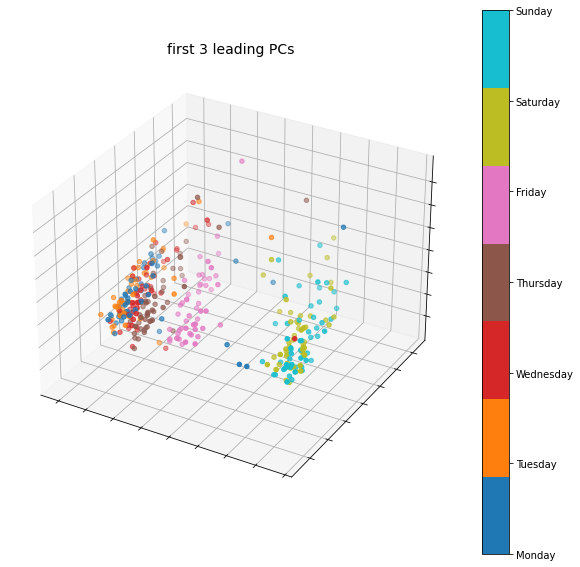

In [36]:
from mpl_toolkits import mplot3d
import matplotlib.colors as mcolors
import matplotlib.cm as cm
df['dow'] = pd.to_datetime(df.index).dayofweek
df['weekend'] = df['dow'] > 4

normalize = mcolors.Normalize(vmin=df['dow'].min(), vmax=df['dow'].max())

# get 7 colors from a colormap name as tab10
colormap = cm.get_cmap('tab10',7)



fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(dfNormalizePC[:,0], dfNormalizePC[:,1], dfNormalizePC[:,2], c=df['dow'],cmap=colormap)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
cbar = plt.colorbar(scalarmappaple)
cbar.ax.set_yticklabels(pd.to_datetime(df.index).day_name().unique())
plt.title('first 3 leading PCs',fontsize=14)

#### selected a proper component amount by BIC score.

In [37]:
bicDict = {}
for i in range(2,11):
    gm = GaussianMixture(n_components=i)
    labels = gm.fit_predict(dfNormalizePC[:,:20])
    score = gm.bic(dfNormalizePC[:,:20])
    bicDict[i] = score

In [38]:
comp = min(bicDict, key=bicDict.get)
comp

2

#### iterative gaussian mixture model. First, fit a gmm on the whole dataset; secondly, exclude data points which likelihood is below a pre-defined threshold. Thirdly, re-train a gmm on the filtered dataset and apply the model to the whole dataset. Lastly, select anomalies based on likelihood.

In [39]:
def anomalyDetection(y,ncom,pval,iterN=20):
    if len(y.shape) == 1:
        y = np.array(y).reshape(-1,1)
    rind = np.array(range(y.shape[0]))
    
    #clustering model
    gm=GaussianMixture(n_components=ncom,n_init=100,max_iter=1000,random_state=0) 
    for i in range(iterN): #iterate
        clustering=gm.fit(y[rind,:]) #fit EM clustering model excluding outliers
        l=clustering.score_samples(y) #estimate likelihood for each point
        Lthres=sorted(l)[int(len(l)*pval)] #anomaly threshold
        rind0=0+rind
        rind=l>Lthres #non-anomalous points
        if all(rind==rind0):
            break
    return l < Lthres

In [40]:
# as we have 18 selected events, let's select 18 days have the lowest likelihood
label = anomalyDetection(dfNormalizePC,comp,18/365)
df['label'] = label
anomaly = df.loc[df['label']==True].index
anomaly = pd.DataFrame({'Date':anomaly})

Text(0.5, 0.92, 'first 3 leading PCs')

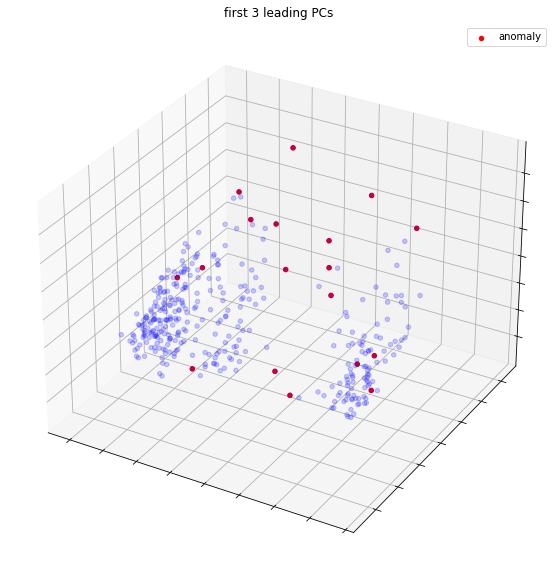

In [41]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(dfNormalizePC[:,0], dfNormalizePC[:,1], dfNormalizePC[:,2],color='blue',alpha=0.2)
ax.scatter3D(dfNormalizePC[:,0][label], dfNormalizePC[:,1][label], 
             dfNormalizePC[:,2][label],color='red',alpha=1,label = 'anomaly')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.legend()
plt.title('first 3 leading PCs')

In [42]:
anomaly['detected'] = 'yes'
results = anomaly.merge(event, on='Date',how='outer')
results['Type'] = results['Type'].fillna('None')
results['Name'] = results['Name'].fillna('None')
results


,Date,detected,Type,Name
0,2018-01-01,yes,National Holiday,New Year's Day
1,2018-01-04,yes,Extreme Weather,Blizzard
2,2018-01-15,yes,National Holiday,"Martin Luther King, Jr. Day"
3,2018-02-19,yes,National Holiday,Washington's Birthday
4,2018-03-07,yes,None,None
5,2018-03-21,yes,Extreme Weather,Snow Storm
6,2018-06-24,yes,None,None
7,2018-07-04,yes,National Holiday,Independence Day
8,2018-09-03,yes,National Holiday,Labour Day
9,2018-09-25,yes,None,None


In [43]:
print('detected days:', len(results.loc[(results['detected']=='yes')]))
print('detected events:', len(results.loc[(results['detected']=='yes')&(results['Type']!='None')]), '/',len(event))
print('undetected events:', len(results.loc[(results['detected']!='yes')&(results['Type']!='None')]), '/',len(event))

detected days: 18
detected events: 11 / 18
undetected events: 7 / 18


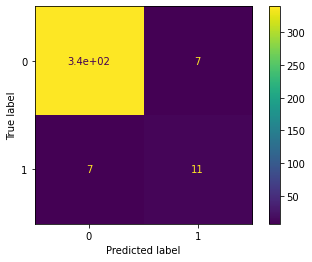

In [44]:
cmdf = pd.DataFrame({'date':dfDaily.index.astype(str)})
cmdf['event'] = 0
cmdf.loc[cmdf.date.isin(event.Date),'event'] = 1
cmdf['anomaly'] = 0
cmdf.loc[cmdf.date.isin(anomaly.Date),'anomaly'] = 1
cm = confusion_matrix(cmdf.anomaly, cmdf.event)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()

In [45]:
f1_score(cmdf.anomaly, cmdf.event)

0.6111111111111112

#### compare to phase 1, more events are detected. Even more false negative we detected, the f1 score still goes higher as true positive increased significantly.

## Phase 3
Time-series analysis of the first 3 PCs, report days with the strongest relative errors from 3 PCs. 

Vector Auto-Regression (VAR)
It is a generalized version of auto regression model for multivariate stationary time series. It is characterized by ‘p’ parameter.

Vector Moving Average (VMA)
It is a generalized version of moving average model for multivariate stationary time series. It is characterized by ‘q’ parameter.

Vector Auto Regression Moving Average (VARMA)
It is the combination of VAR and VMA and a generalized version of ARMA model for multivariate stationary time series. It is characterized by ‘p’ and ‘q’ parameters. Much like, ARMA is capable of acting like an AR model by setting ‘q’ parameter as 0 and as a MA model by setting ‘p’ parameter as 0, VARMA is also capable of acting like an VAR model by setting ‘q’ parameter as 0 and as a VMA model by setting ‘p’ parameter as 0.

Check here for more information: https://towardsdatascience.com/lets-forecast-your-time-series-using-classical-approaches-f84eb982212c

In [46]:
# check stationarity
series = dfNormalizePC[:,0]
result = adfuller(series)
print('p-value: %f' % result[1])
series = dfNormalizePC[:,1]
result = adfuller(series)
print('p-value: %f' % result[1])
series = dfNormalizePC[:,2]
result = adfuller(series)
print('p-value: %f' % result[1])

p-value: 0.099843
p-value: 0.226549
p-value: 0.204069


#### take first order difference

In [47]:
series = dfNormalizePC[:,0]
result = adfuller(np.diff(series))
print('p-value: %f' % result[1])
series = dfNormalizePC[:,1]
result = adfuller(np.diff(series))
print('p-value: %f' % result[1])
series = dfNormalizePC[:,2]
result = adfuller(np.diff(series))
print('p-value: %f' % result[1])

p-value: 0.000000
p-value: 0.000000
p-value: 0.000000


In [48]:
from statsmodels.tsa.statespace.varmax import VARMAX

p = q = range(0, 5)
pq = list(product(p, q))

aicDict = {}
for param in tqdm_notebook(pq):
    try:
        mod = VARMAX(np.diff(dfNormalizePC[:,:3]),order=param)
        results = mod.fit()
        aicDict[param] = results.aic
    except: 
        continue
        

In [49]:
model=VARMAX(dfNormalizePC[:,:3],order=min(aicDict, key=aicDict.get))
results=model.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:     ['y1', 'y2', 'y3']   No. Observations:                  365
Model:                     VARMA(4,3)   Log Likelihood                5555.076
                          + intercept   AIC                         -10966.152
Date:                Thu, 23 Sep 2021   BIC                         -10685.359
Time:                        14:04:41   HQIC                        -10854.561
Sample:                             0                                         
                                - 365                                         
Covariance Type:                  opg                                         
Ljung-Box (Q):          651.90, 46.77, 61.91   Jarque-Bera (JB):   6.95, 9.54, 122.78
Prob(Q):                    0.00, 0.21, 0.01   Prob(JB):             0.03, 0.01, 0.00
Heteroskedasticity (H):     1.24, 0.92, 1.16   Skew:                 0.31, 0.35, 0.25
Prob(H) (two-sided):        0.2

In [50]:
bicDict = {}
for i in range(2,11):
    gm = GaussianMixture(n_components=i)
    labels = gm.fit_predict(results.resid)
    score = gm.bic(results.resid)
    bicDict[i] = score

### apply gaussian mixture model in residuals from VARMA, select 18 days which have the lowest likelihood

In [51]:
comp = min(bicDict, key=bicDict.get)
label = anomalyDetection(results.resid,comp,18/365)
df['label'] = label
anomaly = df.loc[df['label']==True].index
anomaly = pd.DataFrame({'Date':anomaly})

Text(0.5, 0.92, 'first 3 leading PCs')

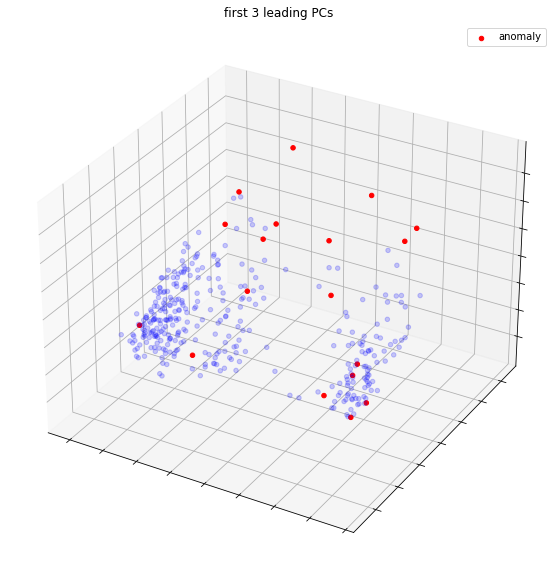

In [52]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(dfNormalizePC[:,0][label == False],
             dfNormalizePC[:,1][label == False], 
             dfNormalizePC[:,2][label == False],color='blue',alpha=0.2)
ax.scatter3D(dfNormalizePC[:,0][label], dfNormalizePC[:,1][label], 
             dfNormalizePC[:,2][label],color='red',alpha=1,label = 'anomaly')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.legend()
plt.title('first 3 leading PCs')

In [53]:
anomaly['Date'] = df[label].index.astype(str)
anomaly = anomaly[['Date']]
anomaly['detected'] = 'yes'
results = anomaly.merge(event, on='Date',how='outer')
results['Type'] = results['Type'].fillna('None')
results['Name'] = results['Name'].fillna('None')
results

,Date,detected,Type,Name
0,2018-01-01,yes,National Holiday,New Year's Day
1,2018-01-04,yes,Extreme Weather,Blizzard
2,2018-01-05,yes,Extreme Weather,Blizzard
3,2018-02-02,yes,None,None
4,2018-05-26,yes,None,None
5,2018-05-29,yes,None,None
6,2018-07-04,yes,National Holiday,Independence Day
7,2018-07-08,yes,None,None
8,2018-09-24,yes,None,None
9,2018-09-29,yes,None,None


In [54]:
print('detected days:', len(results.loc[(results['detected']=='yes')]))
print('detected events:', len(results.loc[(results['detected']=='yes')&(results['Type']!='None')]), '/',len(event))
print('undetected events:', len(results.loc[(results['detected']!='yes')&(results['Type']!='None')]), '/',len(event))

detected days: 18
detected events: 8 / 18
undetected events: 10 / 18


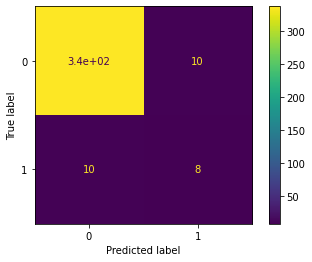

In [55]:
cmdf = pd.DataFrame({'date':dfDaily.index.astype(str)})
cmdf['event'] = 0
cmdf.loc[cmdf.date.isin(event.Date),'event'] = 1
cmdf['anomaly'] = 0
cmdf.loc[cmdf.date.isin(anomaly.Date),'anomaly'] = 1
cm = confusion_matrix(cmdf.anomaly, cmdf.event)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()

In [56]:
f1_score(cmdf.anomaly, cmdf.event)

0.4444444444444444

#### Phase 3's performance is inferior to phase 2.